In [1]:
# from zipfile import ZipFile
# file_name = '/content/archive (6).zip'

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [2]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.regularizers import l2
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [3]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [4]:
# set variables 
images_folder = '/content/img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 5

In [5]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('/content/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [6]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


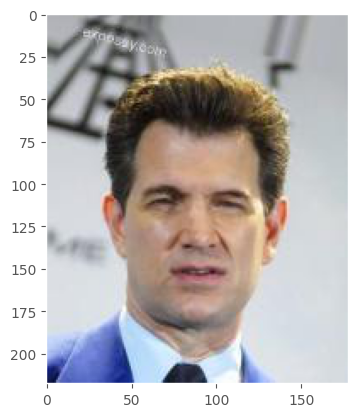

Straight_Hair    1
Male             1
Young            0
Smiling          0
Black_Hair       0
Attractive       0
Name: 000015.jpg, dtype: int64


In [7]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = images_folder + '000015.jpg'

# Load the image using PIL
img = Image.open(img_path)

# Plot the image
plt.grid(False)
plt.imshow(img)
plt.show()

# Access attributes from df_attr
image_filename = img_path.split('/')[-1]
attributes = df_attr.loc[image_filename][['Straight_Hair', 'Male', 'Young','Smiling','Black_Hair','Attractive']]
print(attributes)  # Display the attributes

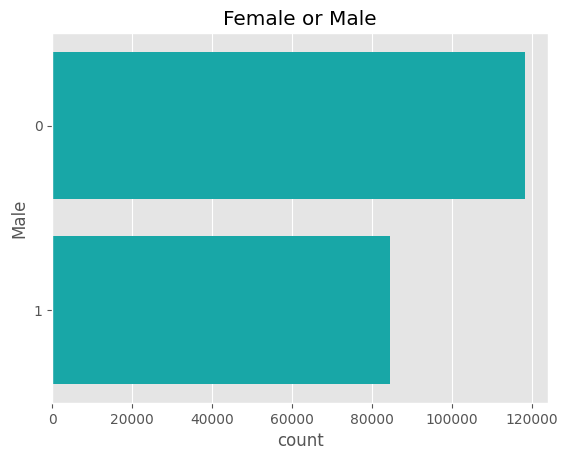

In [8]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [9]:
# Recomended partition
df_partition = pd.read_csv('/content/list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [10]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [11]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [12]:
def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.empty((df_.shape[0], 218, 178, 3), dtype=np.float32)
        y_ = np.empty((df_.shape[0],))

        for i, (index, row) in enumerate(df_.iterrows()):
            im = cv2.imread(images_folder + index)
            im = cv2.resize(im, (178, 218))  # Swap dimensions here
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            x_[i] = im
            y_[i] = row[attr]

        y_ = np_utils.to_categorical(y_, 2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(im, (IMG_WIDTH, IMG_HEIGHT))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis=0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

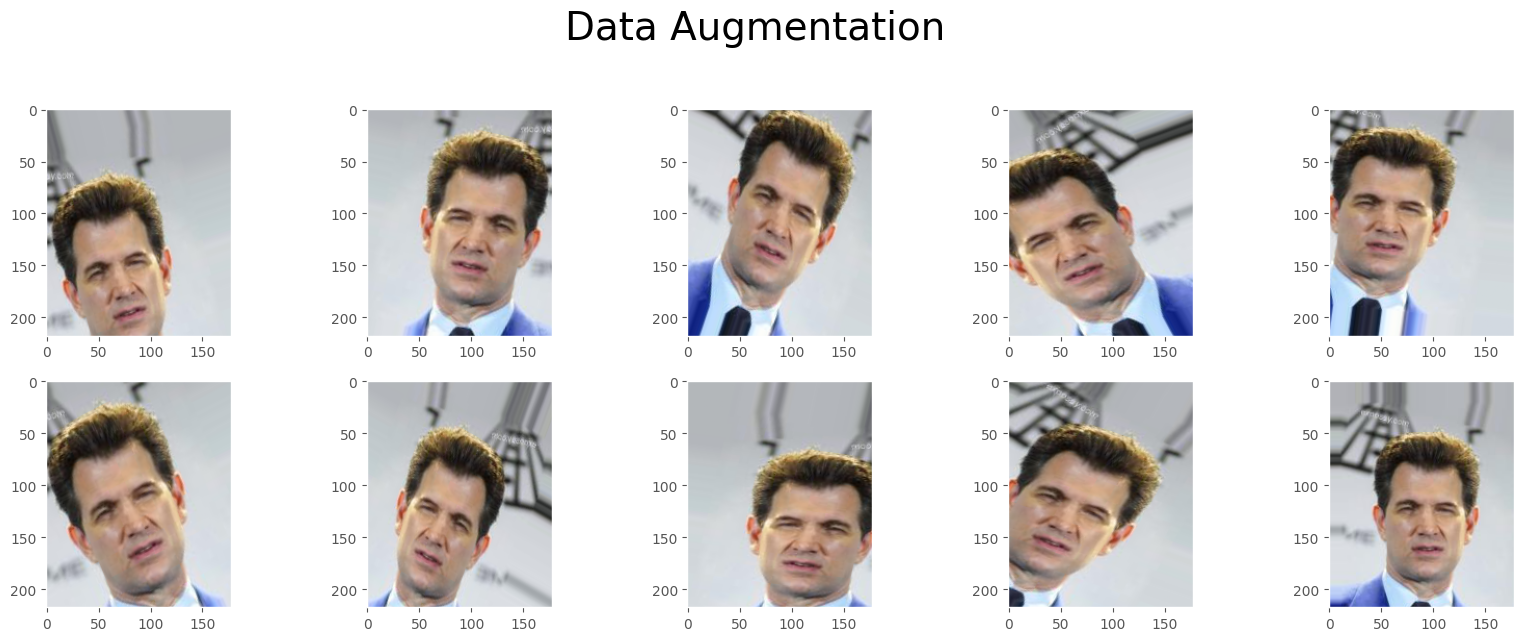

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Generate image generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load one image and reshape
img_path = images_folder + '000015.jpg'
img = Image.open(img_path)
x = np.array(img) / 255.0
x = np.expand_dims(x, axis=0)

# Plot 10 augmented images of the loaded image
plt.figure(figsize=(20, 10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i + 1)
    plt.grid(False)
    plt.imshow(batch.reshape(218, 178, 3))

    if i == 9:
        break
    i += 1

plt.show()

In [14]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [15]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
batch_size=BATCH_SIZE,
)


In [16]:
# file_name = '/content/archive (4).zip'

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [17]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [18]:
# #Adding custom Layers
# x = inc_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu")(x)
# predictions = Dense(2, activation="softmax")(x)

# Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
predictions = Dense(2, activation="softmax")(x)

In [19]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [21]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

<ipython-input-21-e4e330739bfd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator


Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 20.8770 - accuracy: 0.6173
Epoch 1: val_loss improved from inf to 20.68967, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 3468s 6s/step - loss: 20.8770 - accuracy: 0.6173 - val_loss: 20.6897 - val_accuracy: 0.5210
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 20.2435 - accuracy: 0.7474
Epoch 2: val_loss improved from 20.68967 to 20.19415, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 3333s 5s/step - loss: 20.2435 - accuracy: 0.7474 - val_loss: 20.1942 - val_accuracy: 0.5675
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 19.6840 - accuracy: 0.7940
Epoch 3: val_loss improved from 20.19415 to 19.70755, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 3314s 5s/step - loss: 19.6840 - accuracy: 0.7940 - val_loss: 19.7075 - val_accuracy: 0.5585
Epoch 4/5
625/625 [==

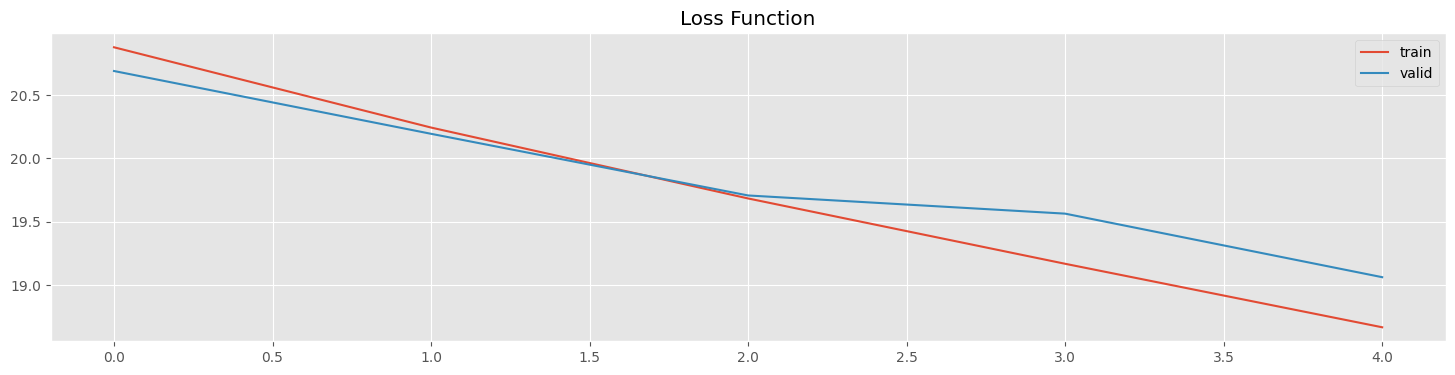

In [22]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

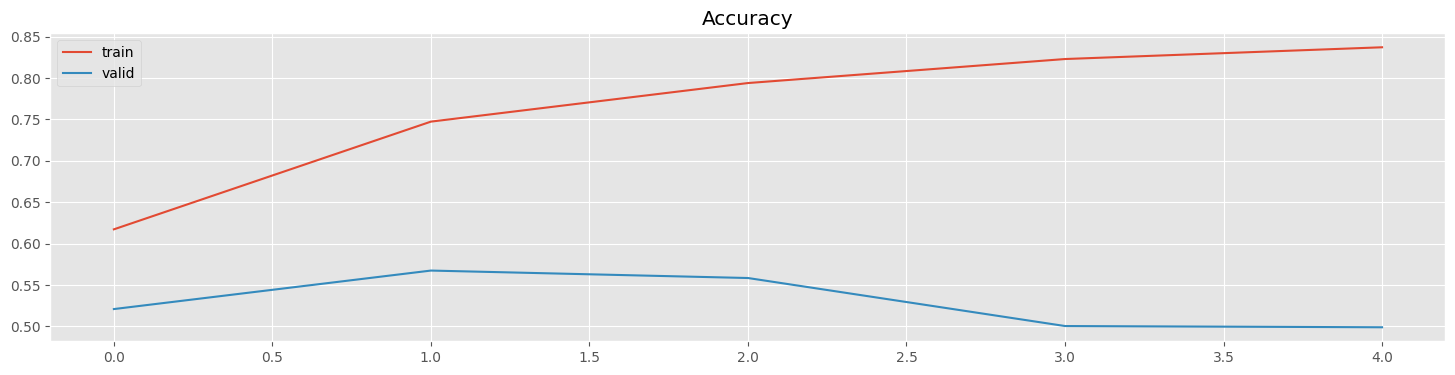

In [23]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [24]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [25]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

1/1 [==============================] - 0s 220ms/step
Model Evaluation
Test accuracy: 49.8500%
f1_score: 0.6582623509369676
